<a href="https://colab.research.google.com/github/Tejaswi-Chaudhari/Toxic-Comment-Classification/blob/main/model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import dependancies

In [215]:
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import nltk
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize 
import sklearn as sk
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report
from scipy.sparse import hstack


Print the version

In [216]:
print('The nltk version is {}.'.format(nltk.__version__))
print('The scikit-learn version is {}.'.format(sk.__version__))

The nltk version is 3.2.5.
The scikit-learn version is 0.22.2.post1.


Import dataset from github

In [217]:
!wget https://raw.githubusercontent.com/dsc-umit/Toxic-Comment-Classification/main/train1.csv

--2021-02-09 17:03:24--  https://raw.githubusercontent.com/dsc-umit/Toxic-Comment-Classification/main/train1.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1373698 (1.3M) [text/plain]
Saving to: ‘train1.csv.8’

train1.csv.8        100%[===================>]   1.31M  --.-KB/s    in 0.09s   

2021-02-09 17:03:24 (14.9 MB/s) - ‘train1.csv.8’ saved [1373698/1373698]



In [218]:
url = 'https://raw.githubusercontent.com/dsc-umit/Toxic-Comment-Classification/main/train1.csv'

Read train.csv<br>
store train.csv in ds1

In [219]:
ds1 = pd.read_csv(url)
print(ds1)

                                                    text sentiment  Label
0          Sooo SAD I will miss you here in San Diego!!!  negative      1
1                              my boss is bullying me...  negative      1
2                         what interview! leave me alone  negative      1
3       Sons of ****, why couldn`t they put them on t...  negative      1
4      2am feedings for the baby are fun when he is a...  positive      0
...                                                  ...       ...    ...
16357                                     enjoy ur night  positive      0
16358   wish we could come see u on Denver  husband l...  negative      1
16359   I`ve wondered about rake to.  The client has ...  negative      1
16360   Yay good for both of you. Enjoy the break - y...  positive      0
16361                         But it was worth it  ****.  positive      0

[16362 rows x 3 columns]


Drop unwanted columns

In [220]:
uds1=ds1.drop(columns=["sentiment"])
uds1.head(10)

,text,Label
0,Sooo SAD I will miss you here in San Diego!!!,1
1,my boss is bullying me...,1
2,what interview! leave me alone,1
3,"Sons of ****, why couldn`t they put them on t...",1
4,2am feedings for the baby are fun when he is a...,0
5,Journey!? Wow... u just became cooler. hehe....,0
6,I really really like the song Love Story by Ta...,0
7,My Sharpie is running DANGERously low on ink,1
8,i want to go to music tonight but i lost my vo...,1
9,"Uh oh, I am sunburned",1


Plot representation

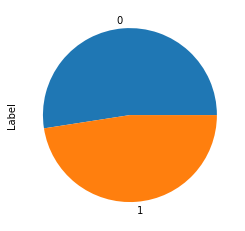

In [221]:
uds1.Label.value_counts().plot(kind='pie')

Convert text to lowercase

In [222]:
uds1["text_lower"] = uds1["text"].str.lower()
uds1.head()

,text,Label,text_lower
0,Sooo SAD I will miss you here in San Diego!!!,1,sooo sad i will miss you here in san diego!!!
1,my boss is bullying me...,1,my boss is bullying me...
2,what interview! leave me alone,1,what interview! leave me alone
3,"Sons of ****, why couldn`t they put them on t...",1,"sons of ****, why couldn`t they put them on t..."
4,2am feedings for the baby are fun when he is a...,0,2am feedings for the baby are fun when he is a...


Drop "text" column

In [223]:
uds1 = uds1.drop(columns=['text'])
uds1.head()

,Label,text_lower
0,1,sooo sad i will miss you here in san diego!!!
1,1,my boss is bullying me...
2,1,what interview! leave me alone
3,1,"sons of ****, why couldn`t they put them on t..."
4,0,2am feedings for the baby are fun when he is a...


Remove punctuation

In [224]:
PUNCT_TO_REMOVE = string.punctuation
def remove_punctuation(text):
    return text.translate(str.maketrans('', '', PUNCT_TO_REMOVE))

uds1["text_wo_punct"] = uds1["text_lower"].apply(lambda text: remove_punctuation(text))
uds1.head(20)

,Label,text_lower,text_wo_punct
0,1,sooo sad i will miss you here in san diego!!!,sooo sad i will miss you here in san diego
1,1,my boss is bullying me...,my boss is bullying me
2,1,what interview! leave me alone,what interview leave me alone
3,1,"sons of ****, why couldn`t they put them on t...",sons of why couldnt they put them on the rel...
4,0,2am feedings for the baby are fun when he is a...,2am feedings for the baby are fun when he is a...
5,0,journey!? wow... u just became cooler. hehe....,journey wow u just became cooler hehe is tha...
6,0,i really really like the song love story by ta...,i really really like the song love story by ta...
7,1,my sharpie is running dangerously low on ink,my sharpie is running dangerously low on ink
8,1,i want to go to music tonight but i lost my vo...,i want to go to music tonight but i lost my voice
9,1,"uh oh, i am sunburned",uh oh i am sunburned


Drop "text_lower" column

In [225]:
uds1 = uds1.drop(columns=['text_lower'])
uds1.head()

,Label,text_wo_punct
0,1,sooo sad i will miss you here in san diego
1,1,my boss is bullying me
2,1,what interview leave me alone
3,1,sons of why couldnt they put them on the rel...
4,0,2am feedings for the baby are fun when he is a...


Remove stopwords

In [226]:
nltk.download('stopwords')
", ".join(stopwords.words('english'))

STOPWORDS = set(stopwords.words('english'))
def remove_stopwords(text):
    return " ".join([word for word in str(text).split() if word not in STOPWORDS])

uds1["text_wo_stop"] = uds1["text_wo_punct"].apply(lambda text: remove_stopwords(text))
uds1.head()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,Label,text_wo_punct,text_wo_stop
0,1,sooo sad i will miss you here in san diego,sooo sad miss san diego
1,1,my boss is bullying me,boss bullying
2,1,what interview leave me alone,interview leave alone
3,1,sons of why couldnt they put them on the rel...,sons couldnt put releases already bought
4,0,2am feedings for the baby are fun when he is a...,2am feedings baby fun smiles coos


Drop "text_wo_punct" column

In [227]:
uds1 = uds1.drop(columns=['text_wo_punct'])
uds1.head()

,Label,text_wo_stop
0,1,sooo sad miss san diego
1,1,boss bullying
2,1,interview leave alone
3,1,sons couldnt put releases already bought
4,0,2am feedings baby fun smiles coos


Tokenization

In [228]:
nltk.download('punkt')
uds1_text=uds1['text_wo_stop']
print(uds1_text)
uds1_text = uds1_text.apply(word_tokenize)
uds1_text.head()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
0                                  sooo sad miss san diego
1                                            boss bullying
2                                    interview leave alone
3                 sons couldnt put releases already bought
4                        2am feedings baby fun smiles coos
                               ...                        
16357                                       enjoy ur night
16358    wish could come see u denver husband lost job ...
16359    ive wondered rake client made clear net dont f...
16360    yay good enjoy break probably need hectic week...
16361                                                worth
Name: text_wo_stop, Length: 16362, dtype: object


0                      [sooo, sad, miss, san, diego]
1                                   [boss, bullying]
2                          [interview, leave, alone]
3    [sons, couldnt, put, releases, already, bought]
4           [2am, feedings, baby, fun, smiles, coos]
Name: text_wo_stop, dtype: object

Insert the tokenized text back in dataframe

In [229]:
uds1.insert(2,"tokenized_text",uds1_text, True)
uds1.head()

,Label,text_wo_stop,tokenized_text
0,1,sooo sad miss san diego,"[sooo, sad, miss, san, diego]"
1,1,boss bullying,"[boss, bullying]"
2,1,interview leave alone,"[interview, leave, alone]"
3,1,sons couldnt put releases already bought,"[sons, couldnt, put, releases, already, bought]"
4,0,2am feedings baby fun smiles coos,"[2am, feedings, baby, fun, smiles, coos]"


Lemmatization

In [230]:
nltk.download('wordnet')

def lemmatize_text(text):
    lemmatizer = WordNetLemmatizer()
    return [lemmatizer.lemmatize(w,'v') for w in text]
    return [lemmatizer.lemmatize(w,'n') for w in text]

uds1['lemmatized_text'] = uds1["tokenized_text"].apply(lemmatize_text)
uds1.head(20)

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


,Label,text_wo_stop,tokenized_text,lemmatized_text
0,1,sooo sad miss san diego,"[sooo, sad, miss, san, diego]","[sooo, sad, miss, san, diego]"
1,1,boss bullying,"[boss, bullying]","[boss, bully]"
2,1,interview leave alone,"[interview, leave, alone]","[interview, leave, alone]"
3,1,sons couldnt put releases already bought,"[sons, couldnt, put, releases, already, bought]","[sons, couldnt, put, release, already, buy]"
4,0,2am feedings baby fun smiles coos,"[2am, feedings, baby, fun, smiles, coos]","[2am, feed, baby, fun, smile, coo]"
5,0,journey wow u became cooler hehe possible,"[journey, wow, u, became, cooler, hehe, possible]","[journey, wow, u, become, cooler, hehe, possible]"
6,0,really really like song love story taylor swift,"[really, really, like, song, love, story, tayl...","[really, really, like, song, love, story, tayl..."
7,1,sharpie running dangerously low ink,"[sharpie, running, dangerously, low, ink]","[sharpie, run, dangerously, low, ink]"
8,1,want go music tonight lost voice,"[want, go, music, tonight, lost, voice]","[want, go, music, tonight, lose, voice]"
9,1,uh oh sunburned,"[uh, oh, sunburned]","[uh, oh, sunburn]"


Stemming

In [231]:
def stem_words(text):
  snow_stemmer = SnowballStemmer(language='english')
  return [snow_stemmer.stem(word) for word in text]


uds1["text_stemmed"] = uds1["lemmatized_text"].apply(lambda text: stem_words(text))
uds1.head()

,Label,text_wo_stop,tokenized_text,lemmatized_text,text_stemmed
0,1,sooo sad miss san diego,"[sooo, sad, miss, san, diego]","[sooo, sad, miss, san, diego]","[sooo, sad, miss, san, diego]"
1,1,boss bullying,"[boss, bullying]","[boss, bully]","[boss, bulli]"
2,1,interview leave alone,"[interview, leave, alone]","[interview, leave, alone]","[interview, leav, alon]"
3,1,sons couldnt put releases already bought,"[sons, couldnt, put, releases, already, bought]","[sons, couldnt, put, release, already, buy]","[son, couldnt, put, releas, alreadi, buy]"
4,0,2am feedings baby fun smiles coos,"[2am, feedings, baby, fun, smiles, coos]","[2am, feed, baby, fun, smile, coo]","[2am, feed, babi, fun, smile, coo]"


Word Vectorization

In [232]:
word_vectorizer = TfidfVectorizer(
    stop_words=None,
    preprocessor=' '.join,
    lowercase=False)
word_vectorizer.fit(uds1["text_stemmed"])
words_vec = word_vectorizer.transform(uds1["text_stemmed"])
uds1.head()

,Label,text_wo_stop,tokenized_text,lemmatized_text,text_stemmed
0,1,sooo sad miss san diego,"[sooo, sad, miss, san, diego]","[sooo, sad, miss, san, diego]","[sooo, sad, miss, san, diego]"
1,1,boss bullying,"[boss, bullying]","[boss, bully]","[boss, bulli]"
2,1,interview leave alone,"[interview, leave, alone]","[interview, leave, alone]","[interview, leav, alon]"
3,1,sons couldnt put releases already bought,"[sons, couldnt, put, releases, already, bought]","[sons, couldnt, put, release, already, buy]","[son, couldnt, put, releas, alreadi, buy]"
4,0,2am feedings baby fun smiles coos,"[2am, feedings, baby, fun, smiles, coos]","[2am, feed, baby, fun, smile, coo]","[2am, feed, babi, fun, smile, coo]"


Character Vectorization

In [233]:
char_vectorizer = TfidfVectorizer(
    preprocessor=' '.join,
    lowercase=False)
char_vectorizer.fit(uds1["text_stemmed"])
char_vec = char_vectorizer.transform(uds1["text_stemmed"])


Combine word and char using hstack

In [234]:
uds1_features = hstack([words_vec, char_vec])
uds1_features

<16362x33290 sparse matrix of type '<class 'numpy.float64'>'
	with 239802 stored elements in COOrdinate format>

Splitting data into train and test ratio (8:2)

In [235]:
uds1_label = uds1["Label"]
text_train, text_test, target_train, target_test = train_test_split(uds1_features, uds1_label, test_size = 0.2, random_state=5)

Define Model

In [236]:
scikit_log_reg = LogisticRegression(C= 1.00)
scikit_log_reg.fit(text_train, target_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

Train the model

In [237]:
scores = []
cv_score = np.mean(cross_val_score(scikit_log_reg, text_train, target_train, cv=3, scoring='roc_auc'))
scores.append(cv_score)
print('Total CV score is {}'.format(np.mean(scores)))

Total CV score is 0.9372303615631888


Test the model

In [238]:
lr_probs = scikit_log_reg.predict_proba(text_test)
lr_probs = lr_probs[:, 1]
lr_auc = roc_auc_score(target_test, lr_probs)
print('Total test score is',lr_auc)

Total test score is 0.9356557567525428


Verify confusion matrix

In [239]:
y_pred = scikit_log_reg.predict(text_test)
cm= confusion_matrix(target_test, y_pred)  
cm
print("Accuracy:",metrics.accuracy_score(target_test, y_pred))
print("Precision:",metrics.precision_score(target_test, y_pred))
print("Recall:",metrics.recall_score(target_test, y_pred))

Accuracy: 0.8661778185151238
Precision: 0.8461538461538461
Recall: 0.8736979166666666


In [240]:
pickle.dump(scikit_log_reg,open('model.pkl','wb'))
pickle.dump(remove_stopwords,open('rstopwords.pkl','wb'))
pickle.dump(word_tokenize,open('tokenize.pkl','wb'))
pickle.dump(word_vectorizer,open('word_vectorizer.pkl','wb'))
pickle.dump(char_vectorizer,open('char_vectorizer.pkl','wb'))
    